In [ ]:
## Librerías
## https://otexts.com/fpp3/index.html

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [6]:

yf.pdr_override()  # Permitir el acceso a Yahoo Finance

# Obtener datos de precios de cierre diarios de Apple desde Yahoo Finance
aapl = pdr.get_data_yahoo('AAPL', start='2022-01-01', end='2022-12-31')


c:\Users\USUARIO\miniconda3\envs\qgz\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [7]:
aapl

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,177.830002,182.880005,177.710007,182.009995,179.724564,104487900
2022-01-04,182.630005,182.940002,179.119995,179.699997,177.443588,99310400
2022-01-05,179.610001,180.169998,174.639999,174.919998,172.723587,94537600
2022-01-06,172.699997,175.300003,171.639999,172.000000,169.840240,96904000
2022-01-07,172.889999,174.139999,171.029999,172.169998,170.008102,86709100
...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,130.959961,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,129.142441,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.179672,85438400


In [8]:

# Tomar solo la columna de precios de cierre para la serie de tiempo
df = aapl[['Close']].reset_index()
df.columns = ['fecha', 'precio_cierre']
df


,fecha,precio_cierre
0,2022-01-03,182.009995
1,2022-01-04,179.699997
2,2022-01-05,174.919998
3,2022-01-06,172.000000
4,2022-01-07,172.169998
...,...,...
246,2022-12-23,131.860001
247,2022-12-27,130.029999
248,2022-12-28,126.040001
249,2022-12-29,129.610001


In [9]:

# Agregar variables retardadas (lags) como características
lags = 3  # Número de retardos
for i in range(1, lags + 1):
    df[f'precio_cierre_retardado_{i}'] = df['precio_cierre'].shift(i)

df


,fecha,precio_cierre,precio_cierre_retardado_1,precio_cierre_retardado_2,precio_cierre_retardado_3
0,2022-01-03,182.009995,NaN,NaN,NaN
1,2022-01-04,179.699997,182.009995,NaN,NaN
2,2022-01-05,174.919998,179.699997,182.009995,NaN
3,2022-01-06,172.000000,174.919998,179.699997,182.009995
4,2022-01-07,172.169998,172.000000,174.919998,179.699997
...,...,...,...,...,...
246,2022-12-23,131.860001,132.229996,135.449997,132.300003
247,2022-12-27,130.029999,131.860001,132.229996,135.449997
248,2022-12-28,126.040001,130.029999,131.860001,132.229996
249,2022-12-29,129.610001,126.040001,130.029999,131.860001


In [10]:

# Eliminar filas con valores NaN resultantes de los retardos
df.dropna(inplace=True)
df

,fecha,precio_cierre,precio_cierre_retardado_1,precio_cierre_retardado_2,precio_cierre_retardado_3
3,2022-01-06,172.000000,174.919998,179.699997,182.009995
4,2022-01-07,172.169998,172.000000,174.919998,179.699997
5,2022-01-10,172.190002,172.169998,172.000000,174.919998
6,2022-01-11,175.080002,172.190002,172.169998,172.000000
7,2022-01-12,175.529999,175.080002,172.190002,172.169998
...,...,...,...,...,...
246,2022-12-23,131.860001,132.229996,135.449997,132.300003
247,2022-12-27,130.029999,131.860001,132.229996,135.449997
248,2022-12-28,126.040001,130.029999,131.860001,132.229996
249,2022-12-29,129.610001,126.040001,130.029999,131.860001


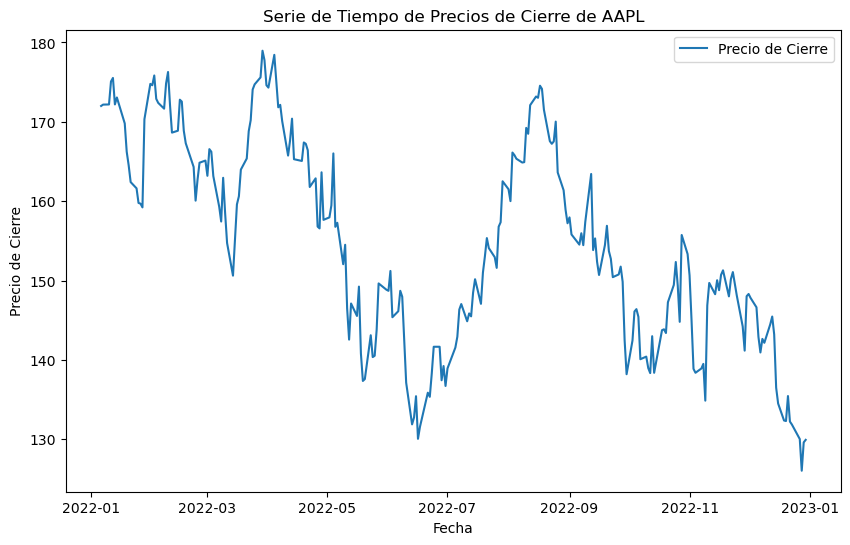

In [11]:

# Visualizar la serie de tiempo de precios de cierre
plt.figure(figsize=(10, 6))
plt.plot(df['fecha'], df['precio_cierre'], label='Precio de Cierre')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.title('Serie de Tiempo de Precios de Cierre de AAPL')
plt.legend()
plt.show()


In [12]:
# Separar los datos en conjunto de entrenamiento y prueba
X = df.drop(['fecha', 'precio_cierre'], axis=1)  # Características
y = df['precio_cierre']  # Variable a predecir

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Escalar los datos para Random Forest (esto puede ser opcional dependiendo del caso)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [14]:
# Crear el modelo de Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)


In [15]:

# Entrenar el modelo
model.fit(X_train_scaled, y_train)


RandomForestRegressor(random_state=42)

In [16]:
# Realizar predicciones
predictions = model.predict(X_test_scaled)


In [17]:

# Calcular el error (RMSE en este caso)
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f'Error RMSE: {rmse}')


Error RMSE: 4.085277628217027


c:\Users\USUARIO\miniconda3\envs\qgz\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
